In [ ]:
import json
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from _drugex_environment import *
from cycler import cycler
from IPython.display import display
from qsprpred.data.tables.qspr import QSPRDataset
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, DataStructs
from scipy.stats import gmean

# set color palette
sns.reset_defaults()

a2arcolors = ["#FFCEAD", "#AAC5AC", "#447464", "#575463", "#9E949D", "#C46D5E", "#F4AC32"]

mpl.rcParams['axes.prop_cycle'] = cycler(color=a2arcolors)
sns.set_palette(a2arcolors)

display(sns.color_palette(a2arcolors))

mpl.rcParams.update({'font.size': 15})
COLOR = '#5A5766'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


[(1.0, 0.807843137254902, 0.6784313725490196),
 (0.6666666666666666, 0.7725490196078432, 0.6745098039215687),
 (0.26666666666666666, 0.4549019607843137, 0.39215686274509803),
 (0.3411764705882353, 0.32941176470588235, 0.38823529411764707),
 (0.6196078431372549, 0.5803921568627451, 0.615686274509804),
 (0.7686274509803922, 0.42745098039215684, 0.3686274509803922),
 (0.9568627450980393, 0.6745098039215687, 0.19607843137254902)]

In [2]:
# Set data paths
config_file = "../config.json"
with open(config_file, "r") as f:
    config = json.load(f)

DNDD_DIR = join(config["BASE_DIR"], config["PROCESSED_DATA_DIR"], "DNDD/")
GRIDSEARCH_DIR = join(DNDD_DIR, "grid_search")
FIGURES_DIR = join(config["BASE_DIR"], config["FIGURES_DIR"], "DNDD", "grid_search")
os.makedirs(FIGURES_DIR, exist_ok=True)

# a2ar model and data paths
QSPR_DIR = join(config["BASE_DIR"], "02_processed", "QSPR")
BEST_DATA_A2AR = join(QSPR_DIR, "data", config["A2AR_DATA"], config["A2AR_DATA"] + "_meta.json")
BEST_DATA_FU = join(QSPR_DIR, "data", config["FU_DATA"], config["FU_DATA"] + "_meta.json")

# list all result folders
gridsearch_folders = os.listdir(GRIDSEARCH_DIR)
gridsearch_folders = [f for f in gridsearch_folders if not f.startswith("conda_env") and not f.startswith("GridSearch")]

# Analyze reinforcement learning grid search
Calculated pefromance metrics for all grid search settings as barplot and table (Supplementary Table S3)

In [3]:
# load in smiles for all datasets
A2AR_smiles = QSPRDataset.fromFile(BEST_DATA_A2AR).df.SMILES.to_list()
FU_smiles = QSPRDataset.fromFile(BEST_DATA_FU).df.SMILES.to_list()

training_smiles = A2AR_smiles + FU_smiles
training_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smiles), canonical=True) for smiles in training_smiles]
training_smiles = list(set(training_smiles))

epsilon0.1_mutatepretrained
epsilon0.2_mutatefinetuned
epsilon0.3_mutatefinetuned
epsilon0.05_mutatepretrained
epsilon0.3_mutatepretrained
epsilon0.2_mutatepretrained
epsilon0.01_mutatefinetuned
epsilon0.01_mutatepretrained
epsilon0.1_mutatefinetuned
epsilon0.05_mutatefinetuned


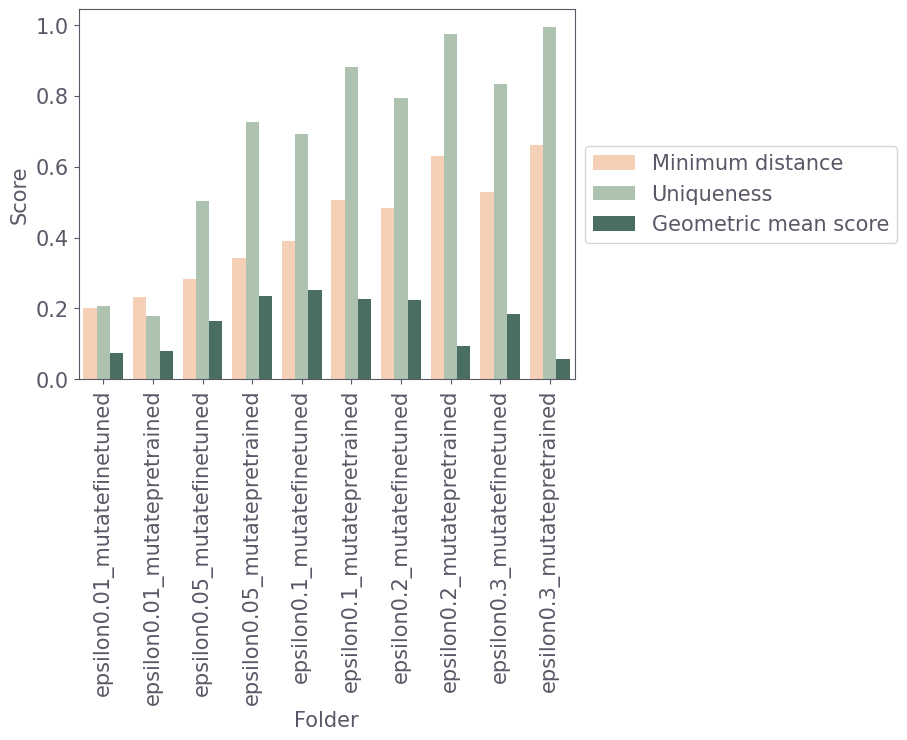

Validity  Uniqueness  Novelty  Geometric mean score  \
Epsilon Mutate model                                                        
0.01    finetuned         1.00        0.21     0.21                  0.07   
        pretrained        1.00        0.18     0.18                  0.08   
0.05    finetuned         0.99        0.50     0.50                  0.16   
        pretrained        0.99        0.73     0.71                  0.23   
0.1     finetuned         0.98        0.69     0.67                  0.25   
        pretrained        0.97        0.88     0.85                  0.23   
0.2     finetuned         0.97        0.80     0.76                  0.22   
        pretrained        0.95        0.97     0.93                  0.09   
0.3     finetuned         0.96        0.83     0.76                  0.18   
        pretrained        0.95        0.99     0.94                  0.06   

                      A2AR score (mean)  FU score (mean)  A2AR applicability  \
Epsilon Mutate model                                                           
0.01    finetuned                  0.17             0.18                0.09   
        pretrained                 0.15             0.16                0.09   
0.05    finetuned                  0.36             0.42                0.22   
        pretrained                 0.47             0.56                0.33   
0.1     finetuned                  0.36             0.53                0.39   
        pretrained                 0.41             0.60                0.40   
0.2     finetuned                  0.30             0.56                0.43   
        pretrained                 0.26             0.52                0.28   
0.3     finetuned                  0.26             0.49                0.41   
        pretrained                 0.23             0.45                0.23   

                      FU applicability  Minimum distance  
Epsilon Mutate model                                      
0.01    finetuned                 0.20              0.20  
        pretrained                0.17              0.23  
0.05    finetuned                 0.48              0.28  
        pretrained                0.69              0.34  
0.1     finetuned                 0.65              0.39  
        pretrained                0.81              0.51  
0.2     finetuned                 0.72              0.48  
        pretrained                0.83              0.63  
0.3     finetuned                 0.72              0.53  
        pretrained                0.81              0.66

In [ ]:
### Calculated pefromance metrics for all grid search settings as barplot and table (Supplementary Table S3)
os.makedirs(f"{FIGURES_DIR}", exist_ok=True)

performance = {}
for folder in gridsearch_folders:
    print(folder)
    rl_fit = pd.read_csv(f"{GRIDSEARCH_DIR}/{folder}/{folder}_sample.tsv", sep="\t")
    
    # add column mean score (mean of A2AR and FUmax score where applicability is 1)
    score_columns = ["A2AR_scorer", "FUmax_scorer"]
    rl_fit['Geometric mean score'] = (
        rl_fit[score_columns].apply(lambda x: gmean(x), axis=1)
        * rl_fit["A2AR_applicability_scorer"]
        * rl_fit["FUmax_applicability_scorer"]
    )
    
    total_number_of_smiles = len(rl_fit)
    
    # calculate number of valid SMILES
    rl_fit['Valid'] = rl_fit['SMILES'].apply(lambda x: Chem.MolFromSmiles(x) is not None)
    total_number_of_valid_smiles = rl_fit["Valid"].sum()
    rl_fit = rl_fit[rl_fit["Valid"] == 1]
    
    # canonicalize SMILES
    rl_fit["Generated_SMILES"] = rl_fit.SMILES
    rl_fit["SMILES"] = [
        Chem.MolToSmiles(Chem.MolFromSmiles(row.SMILES), canonical=True)
        if row.Valid != 0 else None
        for _, row in rl_fit.iterrows()
    ]
    
    # calculate number of unique SMILES
    total_number_of_duplicated_smiles = rl_fit.duplicated(subset=["SMILES"]).sum() 
    rl_fit = rl_fit.drop_duplicates(subset=["SMILES"])
    
    # check if generated SMILES are in the training set
    rl_fit["Novel"] = rl_fit["SMILES"].apply(lambda x: x not in training_smiles)
    total_number_of_novel_smiles = rl_fit["Novel"].sum()
    rl_fit = rl_fit[rl_fit["Novel"] == 1]
    
    #  Calculate minimum similarity between generated SMILES
    rl_fit['mol'] = rl_fit['SMILES'].apply(Chem.MolFromSmiles)
    
    rl_fit['fp'] = rl_fit['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))
    
    # Calculate similarity matrix
    similarity_matrix = pd.DataFrame([
            DataStructs.BulkTanimotoSimilarity(x, rl_fit['fp'].to_list()) for x in rl_fit['fp']
    ])
    distance_matrix = 1 - similarity_matrix
    np.fill_diagonal(distance_matrix.values, np.nan)
    mean_distance = distance_matrix.mean(axis=1)
    min_distance = distance_matrix.min(axis=1)
    max_distance = distance_matrix.max(axis=1)
    
    
    performance[folder] = {
        "Validity": total_number_of_valid_smiles / total_number_of_smiles,
        "Uniqueness": (total_number_of_smiles - total_number_of_duplicated_smiles) / total_number_of_smiles,
        "Novelty": total_number_of_novel_smiles / total_number_of_smiles,
        "Geometric mean score": rl_fit['Geometric mean score'].sum() / total_number_of_smiles,
        "A2AR score": rl_fit['A2AR_scorer'].sum() / total_number_of_smiles,
        "FUmax score": rl_fit['FUmax_scorer'].sum() / total_number_of_smiles,
        "A2AR applicability": rl_fit['A2AR_applicability_scorer'].sum() / total_number_of_smiles,
        "FU applicability": rl_fit['FUmax_applicability_scorer'].sum() / total_number_of_smiles,
        "Minimum distance": min_distance.mean(),
    }
    
    
# make barplot of performance with seaborn
performance_df = pd.DataFrame(performance).T
performance_df = performance_df.reset_index()
performance_df = performance_df.rename(columns={"index": "Folder"})

performance_df_melt = performance_df.melt(
    id_vars="Folder",
    value_vars=["Uniqueness", "Geometric mean score", "Minimum distance"],
    var_name="Performance",
    value_name="Score"
).sort_values(by="Folder")

sns.barplot(data=performance_df_melt, x="Folder", y="Score", hue="Performance")
plt.xticks(rotation=90)

# make plt.xticks in two rows -> pretrained/finetuned and different epsilon values
new_labels = []
for label in performance_df_melt["Folder"]:
    epsilon = label.split("_")[0].removeprefix("epsilon")
    mutate = label.split("_")[1].removeprefix("mutate")
    new_labels.append(f"{epsilon}\n{mutate}")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

performance_df.rename(columns={"A2AR score": "A2AR score (mean)", "FUmax score": "FU score (mean)"}, inplace=True)
performance_df["Epsilon"] = performance_df["Folder"].apply(lambda x: x.split("_")[0].removeprefix("epsilon"))
performance_df["Mutate model"] = performance_df["Folder"].apply(lambda x: x.split("_")[1].removeprefix("mutate"))
performance_df = performance_df.drop(columns=["Folder"]).set_index(["Epsilon", "Mutate model"]).sort_index()
performance_df.round(2).to_csv(f"{FIGURES_DIR}/sample_performance.tsv", sep="\t")
display(performance_df.round(2))